In [1]:
! pip install /pstore/home/shetabs1/code/scifai/

Defaulting to user installation because normal site-packages is not writeable
Processing /pstore/home/shetabs1/code/scifai
  Created wheel for scifai: filename=scifai-0.0.1-py3-none-any.whl size=23042 sha256=d1af5860d3812c725650985ae8e1912606265e35bd88520be25564b9fd750832
  Stored in directory: /local/2779308/pip-ephem-wheel-cache-mets243_/wheels/77/c9/46/be8aac478e8f67c427d0996a39b13c1213341ddb146b974964
Successfully built scifai
  Attempting uninstall: scifai
    Found existing installation: scifai 0.0.1
    Uninstalling scifai-0.0.1:
      Successfully uninstalled scifai-0.0.1
You should consider upgrading via the '/pstore/apps/Python/3.8.3-2020.07/bin/python -m pip install --upgrade pip' command.


In [2]:
import scifai
import matplotlib.pyplot as plt
import scifai.ml.Features as Features
from scifai.ml.AutoFeatureSelection import AutoFeatureSelection
from scifai.ml.FeatureExtractor import FeatureExtractor 
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import h5py
from sklearn.pipeline import  FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from scifai.utils import list_of_dict_to_dict
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns


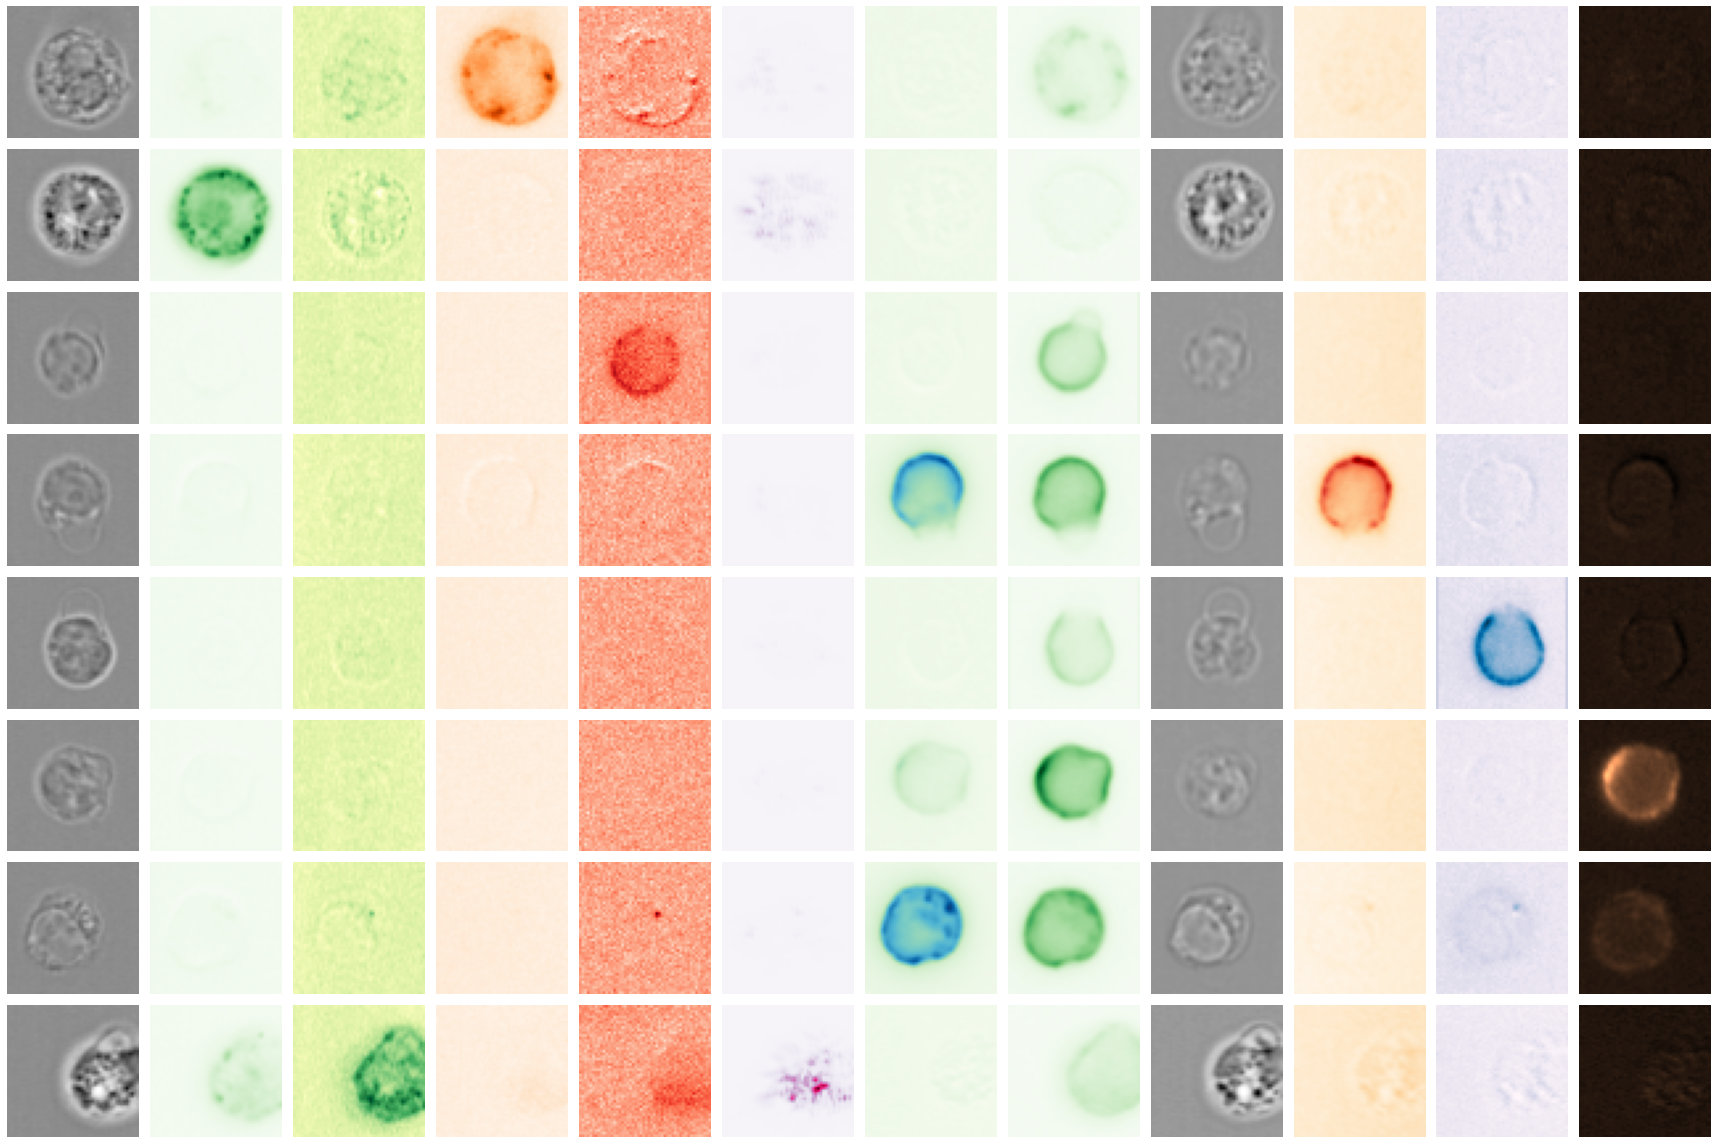

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(estimator, X, y_true, plot = True ): 
    y_pred = estimator.predict(X)
    print("sklearn report", "\n")
    print(classification_report(y_true, y_pred))
    print("\n", "imblanaced report", "\n")
    print(classification_report_imbalanced(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true,cmap = "Greys", xticks_rotation='vertical')
    

In [5]:
data_path = "/pstore/data/DS4/White_blood_cell_dataset/"

feature_union = FeatureUnion([
                                ("MaskBasedFeatures", Features.MaskBasedFeatures()), 
                                ("GLCMFeatures", Features.GLCMFeatures()),  
                                ("GradientRMS", Features.GradientRMS()),  
                                ("BackgroundMean", Features.BackgroundMean()),  
                                ("CellShape", Features.CellShape()),  
                                ("Collocalization", Features.Collocalization())
                                     ],
                                n_jobs = -1)
feature_extractor = FeatureExtractor(feature_union)

In [6]:
%time

metadata = scifai.metadata_generator(data_path)

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 18.4 µs
Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 31280/31280 [01:29<00:00, 347.59it/s]


...metadata prepration ended.


In [7]:
indx = metadata["label"] != "unknown"
metadata = metadata.loc[indx,:]

In [8]:
metadata = metadata.reset_index(drop = True)


In [19]:
metadata.groupby('label').apply(lambda s: s.sample(1)).reset_index(drop = True)

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,21347,labeled,CD14+ monocyte
1,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,13695,labeled,CD15+ neutrophil
2,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,10833,labeled,CD19+ B
3,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,13830,labeled,CD4+ T
4,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,29487,labeled,CD56+ NK
5,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,12246,labeled,CD8+ T
6,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,10348,labeled,NKT
7,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,10442,labeled,eosinophil


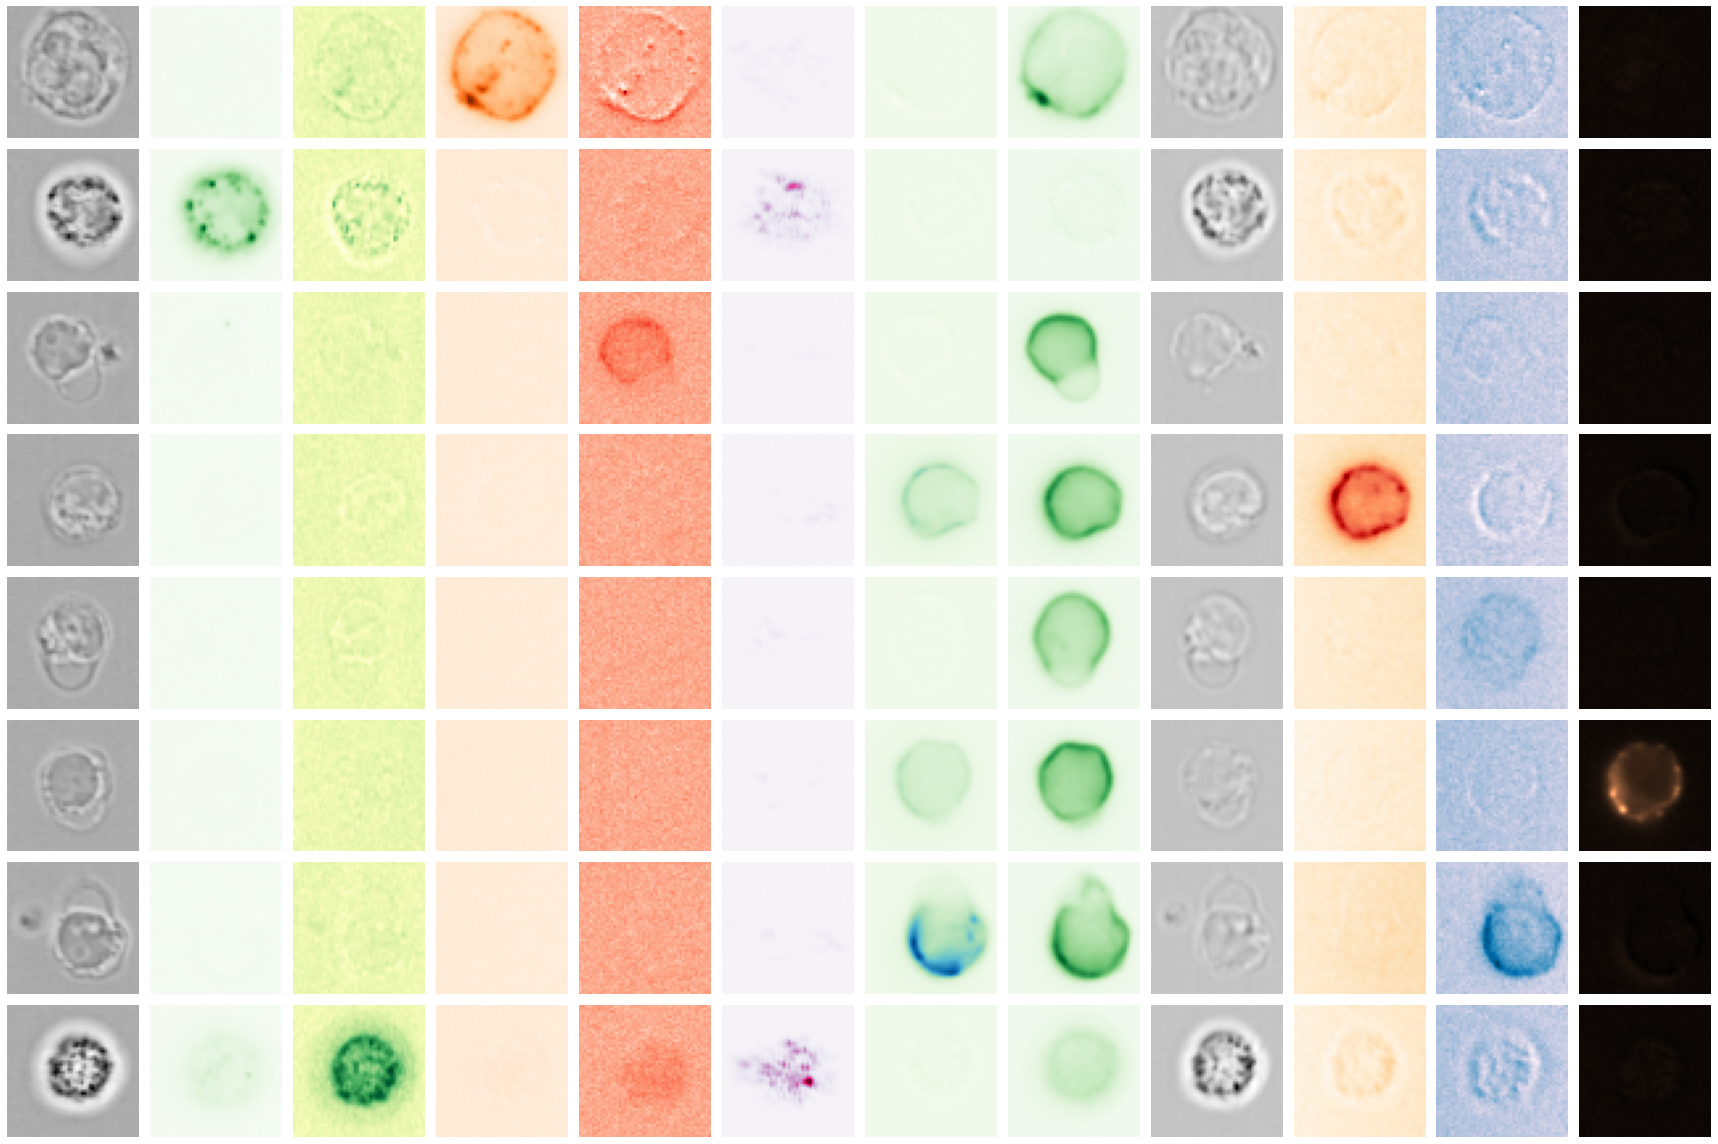

In [37]:
from skimage.util import crop

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].axis('off')
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1)).reset_index(drop = True) ,  
                              figsize = None,
                    channel_colors =  ["Greys", "Greens","YlGn", "Oranges", "Reds", "PuRd","GnBu","Greens","Greys","OrRd","PuBu","copper"],
                    image_size = 50)

In [ ]:
df_features = feature_extractor.extract_features(metadata)

In [ ]:
df_features = df_features.fillna(0.)

In [ ]:
indx = metadata["set"] == "labeled"

index_train , index_test = train_test_split(metadata.loc[indx,:].index, 
                                            stratify = metadata.loc[indx,"label"])

In [ ]:
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler,ADASYN, SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline( steps = [
            ("MinMaxScaler",MinMaxScaler()),
            ("AutoFeatureSelection",AutoFeatureSelection(top_k = 10, correlation_threshold = 0.80 ,verbose=True)),
            ("RandomOverSampler",RandomOverSampler()),
            ("RandomForestClassifier",RandomForestClassifier(n_jobs = -1 ) )
] ,verbose=True )
                            
pipeline.fit(df_features.loc[index_train,:],  
             metadata.loc[index_train, "label"])

In [ ]:
selected_features = pipeline.steps[1][1].selected_features
selected_feature_names = df_features.columns[selected_features]

In [ ]:
classification_complete_report(pipeline, 
                               df_features.loc[index_test,:], 
                               metadata.loc[index_test, "label"])

In [ ]:

from sklearn.inspection import permutation_importance


number_of_important_features = min(len(selected_features), 10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

tree_importance_sorted_idx = np.argsort(pipeline.steps[3][1].feature_importances_)[-1*number_of_important_features:]

tree_indices = np.arange(0, number_of_important_features) + 0.5

ax1.barh(tree_indices, 
         pipeline.steps[3][1].feature_importances_[tree_importance_sorted_idx], 
         height=0.7, color  = "grey")
ax1.set_yticklabels(df_features.columns[selected_features].values[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)


result = permutation_importance(pipeline, 
                                df_features.loc[index_test,:],  
                                metadata.loc[index_test, "label"], n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-1*number_of_important_features:]
ax2.boxplot(result.importances[perm_sorted_idx].T, 
            vert=False,
            labels=df_features.columns.values[perm_sorted_idx])

fig.tight_layout()